In [ ]:
from IPython.display import clear_output

import torch
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from IPython.display import display

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import sys
sys.path.append("..")

2025-05-16 15:24:46.972119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 15:24:46.993254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747401887.018342    1059 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747401887.025900    1059 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 15:24:47.052773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from tracksterLinker.datasets.GNNDataset import ClusterDataset
from tracksterLinker.GNN.trainGNN import *
from tracksterLinker.utils.dataStatistics import *
from tracksterLinker.GNN.TrackLinkingNet import GNN_TrackLinkingNet, weight_init

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
print_dataset_statistics(dataset_training)

Number of events in training dataset: 299


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Number of nodes: 8710
Mean Number of nodes: 29.130434782608695
Number of edges: 53836
Mean Number of edges: 180.05351170568562
Number of positive edges: 47377
Mean Number of positive edges: 158.45150756835938
Number of negative edges: 6459
Mean Number of negative edges: 21.602006912231445


In [5]:
print_dataset_statistics(dataset_test)

Number of events in training dataset: 100
Number of nodes: 2891
Mean Number of nodes: 28.91
Number of edges: 17805
Mean Number of edges: 178.05
Number of positive edges: 15627
Mean Number of positive edges: 156.27000427246094
Number of negative edges: 2178
Mean Number of negative edges: 21.780000686645508


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [39]:
model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True,
                               dropout=0.3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.apply(weight_init)

weights = torch.load(model_folder + "/epoch_200_date_2025-05-15_loss_25.7733.pt", weights_only=True)
model.load_state_dict(weights["model_state_dict"])
optimizer.load_state_dict(weights["optimizer_state_dict"])

model.eval()

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

GNN_TrackLinkingNet(
  (layer): LeakyReLU(negative_slope=0.01)
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.0

In [114]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True, rotation=90)
        plt.xlabel(axis_title)
        plt.title(title)

## Run Feature Importance on Feature input network

In [166]:
xs = []
for sample in train_dl:
    x = sample.x
    x = torch.nan_to_num(x, nan=0.0)
    
    X_norm = torch.zeros_like(x)
    epsilon = 10e-5 * torch.ones(x.shape)
    std = x.std(dim=0, unbiased=False) + epsilon
    X_norm = (x - x.mean(dim=0)) / std
    xs.extend(X_norm)
    
#     if(len(xs) > 10000):
#         break

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

In [167]:
test_tensor = torch.tensor(np.array(xs)).float().to(device)
test_tensor.shape
test_tensor.requires_grad_()

tensor([[ 9.6369e-01, -1.3269e+00, -1.6986e+00,  ...,  2.3979e+00,
          0.0000e+00,  1.1527e+00],
        [ 8.7728e-01, -1.6305e+00, -1.3472e+00,  ...,  5.3439e-01,
          0.0000e+00, -8.4508e-01],
        [ 1.4145e+00, -1.2838e+00, -9.3102e-01,  ..., -5.6180e-01,
          0.0000e+00, -8.4508e-01],
        ...,
        [ 1.9269e-01, -5.3311e-01,  1.1896e+00,  ..., -5.2966e-01,
          2.7756e-13, -6.4324e-01],
        [-1.6130e+00,  6.6839e-02,  1.6696e+00,  ...,  1.0439e-01,
          2.7756e-13,  1.5826e+00],
        [-1.5051e+00, -1.3969e+00,  1.7727e+00,  ..., -6.8817e-01,
          2.7756e-13, -6.4324e-01]], device='cuda:0', requires_grad=True)

In [168]:
ig = IntegratedGradients(model.inputnetwork)

In [169]:
model.inputnetwork(test_tensor).shape

torch.Size([8710, 16])

In [170]:
attrs = []

attrs = ig.attribute(test_tensor, target=0, return_convergence_delta=False).to(cpu).detach().numpy()

for i in range(15):
    attr = ig.attribute(test_tensor, target=1, return_convergence_delta=False).to(cpu).detach().numpy()
    attrs = np.append(attrs, attr, axis=0)

attrs.shape

(139360, 29)

In [171]:
feature_vals = np.mean(attr, axis=0)

In [175]:
feature_vals

array([ 1.0263405e-03,  4.2866272e-05, -1.4652627e-02,  2.0264441e-03,
        1.2734534e-01, -7.6283538e-04, -1.5919084e-03,  4.8178756e-03,
       -7.8993573e-05, -4.8923510e-04,  2.5036766e-03,  6.8935723e-04,
        1.0068733e-04, -9.0915640e-04, -1.0721077e-02,  1.4121169e-02,
       -5.4397476e-03,  5.9269955e-03, -2.6460278e-03, -9.6775686e-08,
        3.9979042e-08, -6.0223158e-08,  3.2041583e-03, -5.9090539e-08,
       -9.5529938e-03, -8.0484245e-03, -9.5819477e-03,  1.6745947e-16,
       -1.3942017e-02], dtype=float32)

Average Feature Importances
barycenter_x :  0.001
barycenter_y :  0.000
barycenter_z :  -0.015
barycenter_eta :  0.002
barycenter_phi :  0.127
eVector0_x :  -0.001
eVector0_y :  -0.002
eVector0_z :  0.005
EV1 :  -0.000
EV2 :  -0.000
EV3 :  0.003
sigmaPCA1 :  0.001
sigmaPCA2 :  0.000
sigmaPCA3 :  -0.001
num_LCs :  -0.011
num_hits :  0.014
raw_energy :  -0.005
raw_em_energy :  0.006
photon_prob :  -0.003
electron_prob :  -0.000
muon_prob :  0.000
neutral_pion_prob :  -0.000
charged_hadron_prob :  0.003
neutral_hadron_prob :  -0.000
z_min :  -0.010
z_max :  -0.008
LC_density :  -0.010
trackster_density :  0.000
time :  -0.014


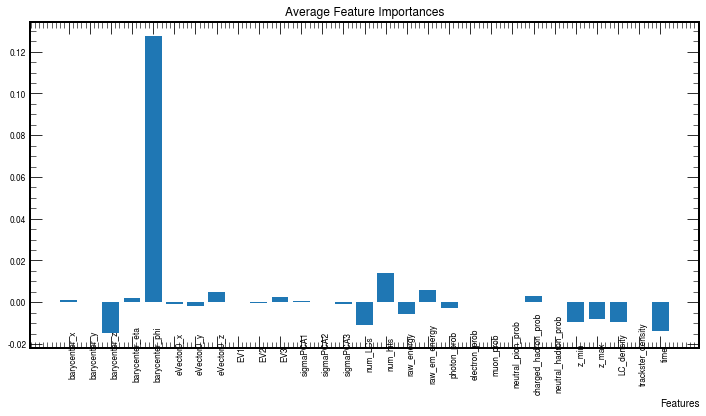

In [172]:
visualize_importances(dataset_training.node_feature_keys, feature_vals)

In [177]:
np.where(np.abs(feature_vals) > 0.001)[0]

array([ 0,  2,  3,  4,  6,  7, 10, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28])

In [174]:
np.array(dataset_training.node_feature_keys)[np.where(feature_vals > 0)[0]]

array(['barycenter_x', 'barycenter_y', 'barycenter_eta', 'barycenter_phi',
       'eVector0_z', 'EV3', 'sigmaPCA1', 'sigmaPCA2', 'num_hits',
       'raw_em_energy', 'muon_prob', 'charged_hadron_prob',
       'trackster_density'], dtype='<U19')

In [104]:
cond = LayerConductance(model.inputnetwork, model.inputnetwork[1])
cond_vals = cond.attribute(test_tensor,target=1)
cond_vals = cond_vals.to(cpu).detach().numpy()

Average Neuron Importances
0 :  0.138
1 :  -0.009
2 :  -0.031
3 :  0.013
4 :  -0.012
5 :  -0.026
6 :  0.003
7 :  0.002
8 :  0.003
9 :  -0.026
10 :  -0.010
11 :  0.006
12 :  0.000
13 :  -0.024
14 :  0.001
15 :  0.049


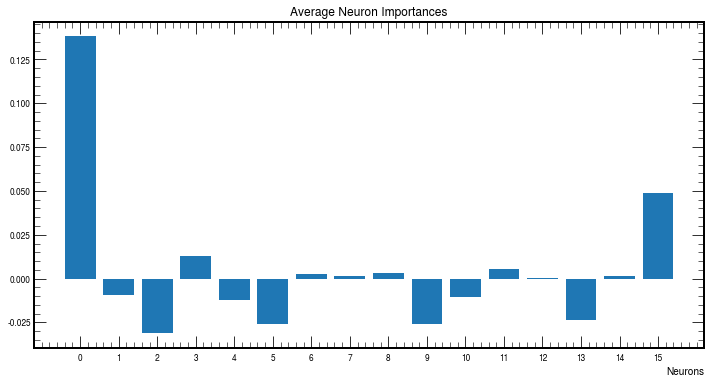

In [105]:
visualize_importances(range(16),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

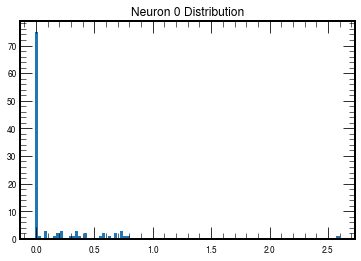

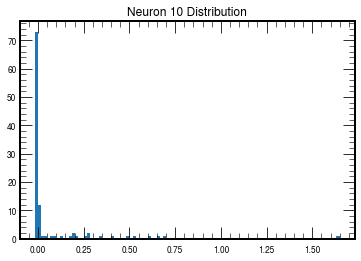

In [92]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,15], 100);
plt.title("Neuron 10 Distribution");

In [89]:
neuron_cond = NeuronConductance(model.inputnetwork, model.inputnetwork[1])

In [90]:
neuron_cond_vals = neuron_cond.attribute(test_tensor, neuron_selector=0, target=1)

Average Feature Importances for Neuron
barycenter_x :  0.000
barycenter_y :  0.000
barycenter_z :  0.004
barycenter_eta :  -0.000
barycenter_phi :  0.109
eVector0_x :  -0.000
eVector0_y :  0.000
eVector0_z :  0.004
EV1 :  0.002
EV2 :  0.000
EV3 :  0.000
sigmaPCA1 :  -0.000
sigmaPCA2 :  -0.000
sigmaPCA3 :  0.000
num_LCs :  0.000
num_hits :  0.011
raw_energy :  -0.009
raw_em_energy :  -0.003
photon_prob :  0.002
electron_prob :  -0.000
muon_prob :  -0.000
neutral_pion_prob :  -0.000
charged_hadron_prob :  -0.000
neutral_hadron_prob :  -0.000
z_min :  0.002
z_max :  -0.004
LC_density :  0.006
trackster_density :  -0.000
time :  0.011


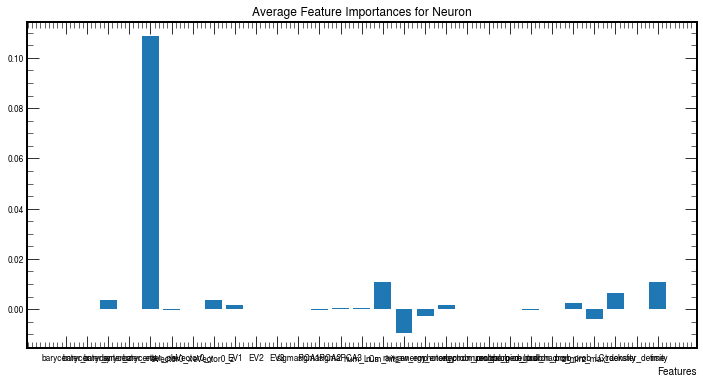

In [91]:
visualize_importances(dataset_training.node_feature_keys, neuron_cond_vals.to(cpu).mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron")

## Try feature importance on full network (Not working)

In [ ]:
sample = next(iter(train_dl))[0]
sample = sample.to(device)
data = prepare_network_input_data(sample.x, sample.edge_index, edge_features=sample.edges_features)

for d in data:
    d.requires_grad_()

In [ ]:
model(*data, device=device)

In [ ]:
ig = IntegratedGradients((lambda x, edge_index, edge_features: model(x, edge_index, edge_features, device=device)))
# ig = IntegratedGradients(model)

In [ ]:
attr, delta = ig.attribute(data, target=1, return_convergence_delta=True)
attr = attr.to(cpu).detach().numpy()